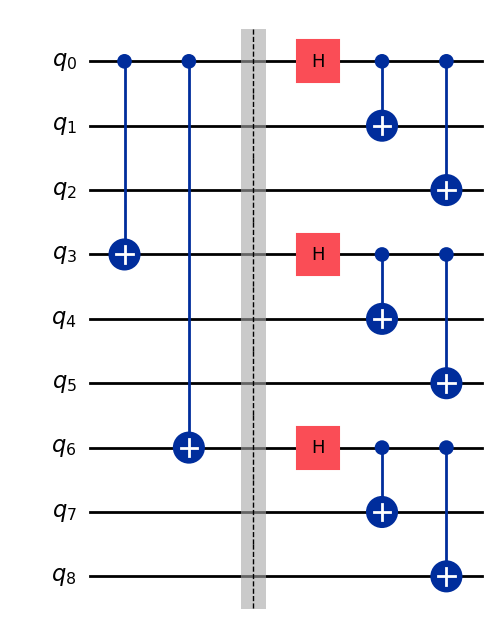

In [1]:
from shor_code_package.shor_code import ShorQubit, ShorCircuit, ConcatenatedShorQubit
from qiskit.quantum_info import Operator, Statevector, StabilizerState
import qiskit.quantum_info as qi
from qiskit import AncillaRegister, QuantumCircuit, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np



sc = ShorQubit()
encoder = sc.encoder()
encoder.draw('mpl')

s = Statevector.from_label("0"*9)
s2 = s.evolve(Operator(encoder))
s2.draw('latex')

encoder.draw('mpl')

In [ ]:
class ConcatenatedShorQubit:
    """
    Class for constructing concatenations of the Shor nine qubit code recursively.
    """

    def __init__(self, n):
        """
        Initializes the class. n is number of concatenations of Shor nine qubit code with itself.
        """
        if n < 2:
            raise Exception("n must be greater than 1.")
        self.n = n
        self.num_qubits = 9**n #physical qubits
        self.num_ancillas = 1
        self._inner_code = ConcatenatedShorQubit(n - 1) if n > 2 else ShorQubit()

    def encoder(self):
        """
        Create the encoding circuit of a single (logical) qubit to 9^n physical qubits.
        The qubit whose state should be encoded in the concatenated Shor code has index 0.
        """
        #Initialize circuit
        qc = QuantumCircuit(self.num_qubits)
        indices = np.split(np.arange(self.num_qubits), 9)
        first_qubit_of_each_group = [sub_indices[0] for sub_indices in indices]

        #Add outer encoder
        qc.compose(ShorQubit().encoder(), qubits = first_qubit_of_each_group, inplace=True)
        qc.barrier()

        #Add inner encoders
        for sub_indices in indices:
            qc.compose(self._inner_code.encoder(), qubits = sub_indices, inplace = True)

        return qc
    
    def syndrome_correction_circuit(self):
        pass
    
    def _add_syndrome_correction(self):
        pass

    def get_stabilizers(self):
        """
        Get the stabilizers for the outer code. These are constructed using the logical X and Z operations on the inner level
        logical states.
        """
        #Set up needed components for the stabilizer circuit.
        shor_code_stabilizers = ["XXXXXXIII", "IIIXXXXXX", "ZZIIIIIII", "IZZIIIIII", "IIIZZIIII", "IIIIZZIII", "IIIIIIZZI", "IIIIIIIZZ"]
        groups = np.split(np.arange(self.num_qubits), 9) #Nine groupings of qubits.
        xl = self._inner_code.logical_X()
        zl = self._inner_code.logical_Z()

        #Construct each stabilizer circuit
        stabilizer_circuits = []
        for stabilizer in shor_code_stabilizers:
            qc = QuantumCircuit(self.num_qubits)
            for i, pauli in enumerate(stabilizer):
                match(pauli):
                    case "X":
                        qc.compose(xl, qubits = groups[i], inplace = True)
                    case "Z":
                        qc.compose(zl, qubits = groups[i], inplace = True)
                    case "I":
                        pass #Do nothing for the identity.
            stabilizer_circuits.append(qc)
        
        return stabilizer_circuits
        

                
            




    
csq = ConcatenatedShorQubit(2)#.encoder()
#np.split(np.arange(81), 9)
qc = csq.encoder()
#qc.save_stabilizer()
#display(qc.draw())
#qc.measure_all()
csq.num_qubits


81

In [7]:
aer = AerSimulator(method = "stabilizer")
res = aer.run(transpile(qc, aer), shots = 100)

qc.num_qubits//9

9

In [ ]:
result = res.result()

#print(result)
stabs = result.data()['stabilizer']
#qc.draw()
len(stabs)

StabilizerState(qc).probabilities_dict()

/var/folders/rs/97dd3psn4t9g5hrhtc9qb4pm0000gn/T/ipykernel_17893/453975406.py:6: DeprecationWarning: The return type of saved stabilizers has been changed from a `dict` to a `qiskit.quantum_info.StabilizerState` as of qiskit-aer 0.10. Accessing dict attributes is deprecated and will result in an error in a future release. Use the `.clifford.to_dict()` methods to access  the stored Clifford operator and convert to a dictionary.
  len(stabs)


In [20]:
qc = QuantumCircuit(1)

s = StabilizerState(qc)
target = StabilizerState.from_stabilizer_list('Z')


s.probabilities_dict()
target.probabilities_dict()

s.equiv(target)

True

In [25]:
zl = "X"*9
xl = "Z"*9
il = "I"*9
zll = 9*xl
concatenated_code_stabilizer = [6*xl + 3*il, 
                                3*il + 6*xl, 
                                2*zl + 7*il, 
                                1*il + 2*zl + 6*il,
                                3*il + 2*zl + 4*il,
                                4*il + 2*zl + 3*il,
                                6*il + 2*zl + 1*il,
                                7*il + 2*zl,
                                ]


concatenated_code_stabilizer[0]

'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZIIIIIIIIIIIIIIIIIIIIIIIIIII'

In [28]:

shor_code_stabilizers = ["XXXXXXIII", "IIIXXXXXX", "ZZIIIIIII", "IZZIIIIII", "IIIZZIIII", "IIIIZZIII", "IIIIIIZZI", "IIIIIIIZZ"]
zl = "X"*9
xl = "Z"*9
il = "I"*9
zll = 9*xl
concatenated_code_stabilizer = [6*xl + 3*il, 
                                3*il + 6*xl, 
                                2*zl + 7*il, 
                                1*il + 2*zl + 6*il,
                                3*il + 2*zl + 4*il,
                                4*il + 2*zl + 3*il,
                                6*il + 2*zl + 1*il,
                                7*il + 2*zl,
                                ]
inner_code_stabilizers = [n * il + scs + (8-n) * il for n in range(9) for scs in shor_code_stabilizers]

inner_code_stabilizers

StabilizerState.from_stabilizer_list([*concatenated_code_stabilizer, *inner_code_stabilizers, zll])

StabilizerState(['+ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ', '+XXXXXXXXXXXXXXXXXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IIIIIIIIIXXXXXXXXXXXXXXXXXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IIIIIIIIIIIIIIIIIIIIIIIIIIIXXXXXXXXXXXXXXXXXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXXXXXXXXXXXXXXXXXIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXXXXXXXXXXXXXXXXXIIIIIIIII', '+IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXXXXXXXXXXXXXXXXX', '+XXXXXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IIIXXXXXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', '+ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', '+IZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [2]:
ghz = Statevector([1/np.sqrt(2),0,0,0,0,0,0,1/np.sqrt(2)])
target = ghz.copy() ^ ghz.copy() ^ ghz.copy()
target.is_valid()
target.draw('latex')

#qc = QuantumCircuit(9)
#qc.x(0)
#qc.compose(ShorQubit().encoder(), inplace=True)
#qc.draw('mpl')
ghz.draw('latex')

<IPython.core.display.Latex object>

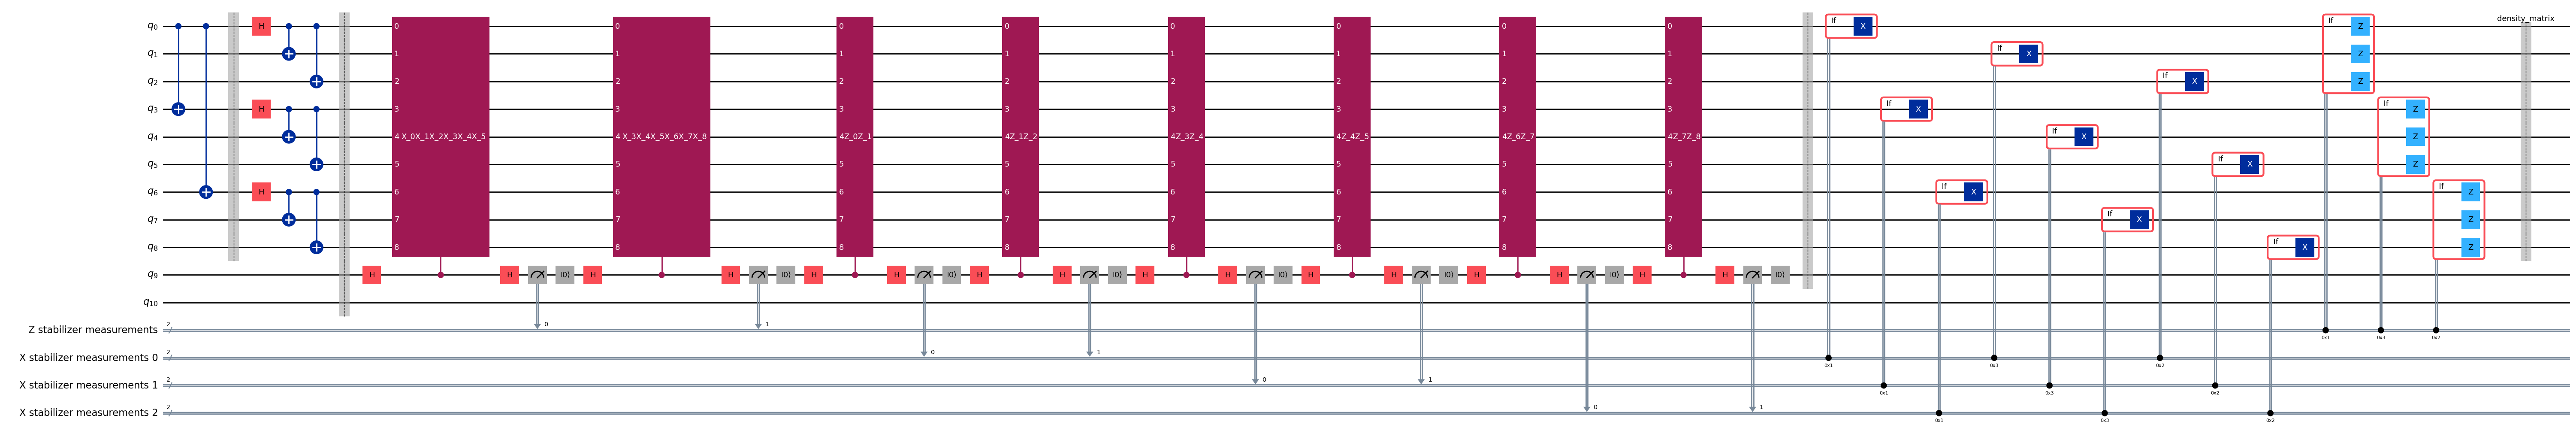

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{'00 00 00 00': 1}

In [5]:
aer = AerSimulator(method="statevector")

sc = ShorQubit()

qc = QuantumCircuit(11)
qc.compose(ShorQubit().encoder(), inplace = True)
qc.barrier()

#qc.z(0)
#qc.z(4)
#qc.x(7)

#qc.y(0)
#qc.y(5)
#qc.x(5)
#qc.y(8)
#qc.h(8)

#qc.z(1)

qc.compose(ShorQubit().syndrome_correction_circuit(True), inplace = True)
qc.save_density_matrix(range(9))

display(qc.draw('mpl', fold = -1))

res = aer.run(qc.decompose(), shots = 1)

def logical_1():
    ghz = qi.Statevector([1/np.sqrt(2), 0, 0, 0, 0, 0, 0, -1/np.sqrt(2)])
    return ghz ^ ghz ^ ghz
def logical_0():
    ghz = qi.Statevector([1/np.sqrt(2), 0, 0, 0, 0, 0, 0, 1/np.sqrt(2)])
    return ghz ^ ghz ^ ghz

s = res.result().data()['density_matrix']

display(logical_0().draw('latex'))
display(s.to_statevector().draw('latex'))
display(logical_1().draw('latex'))

res.result().get_counts()


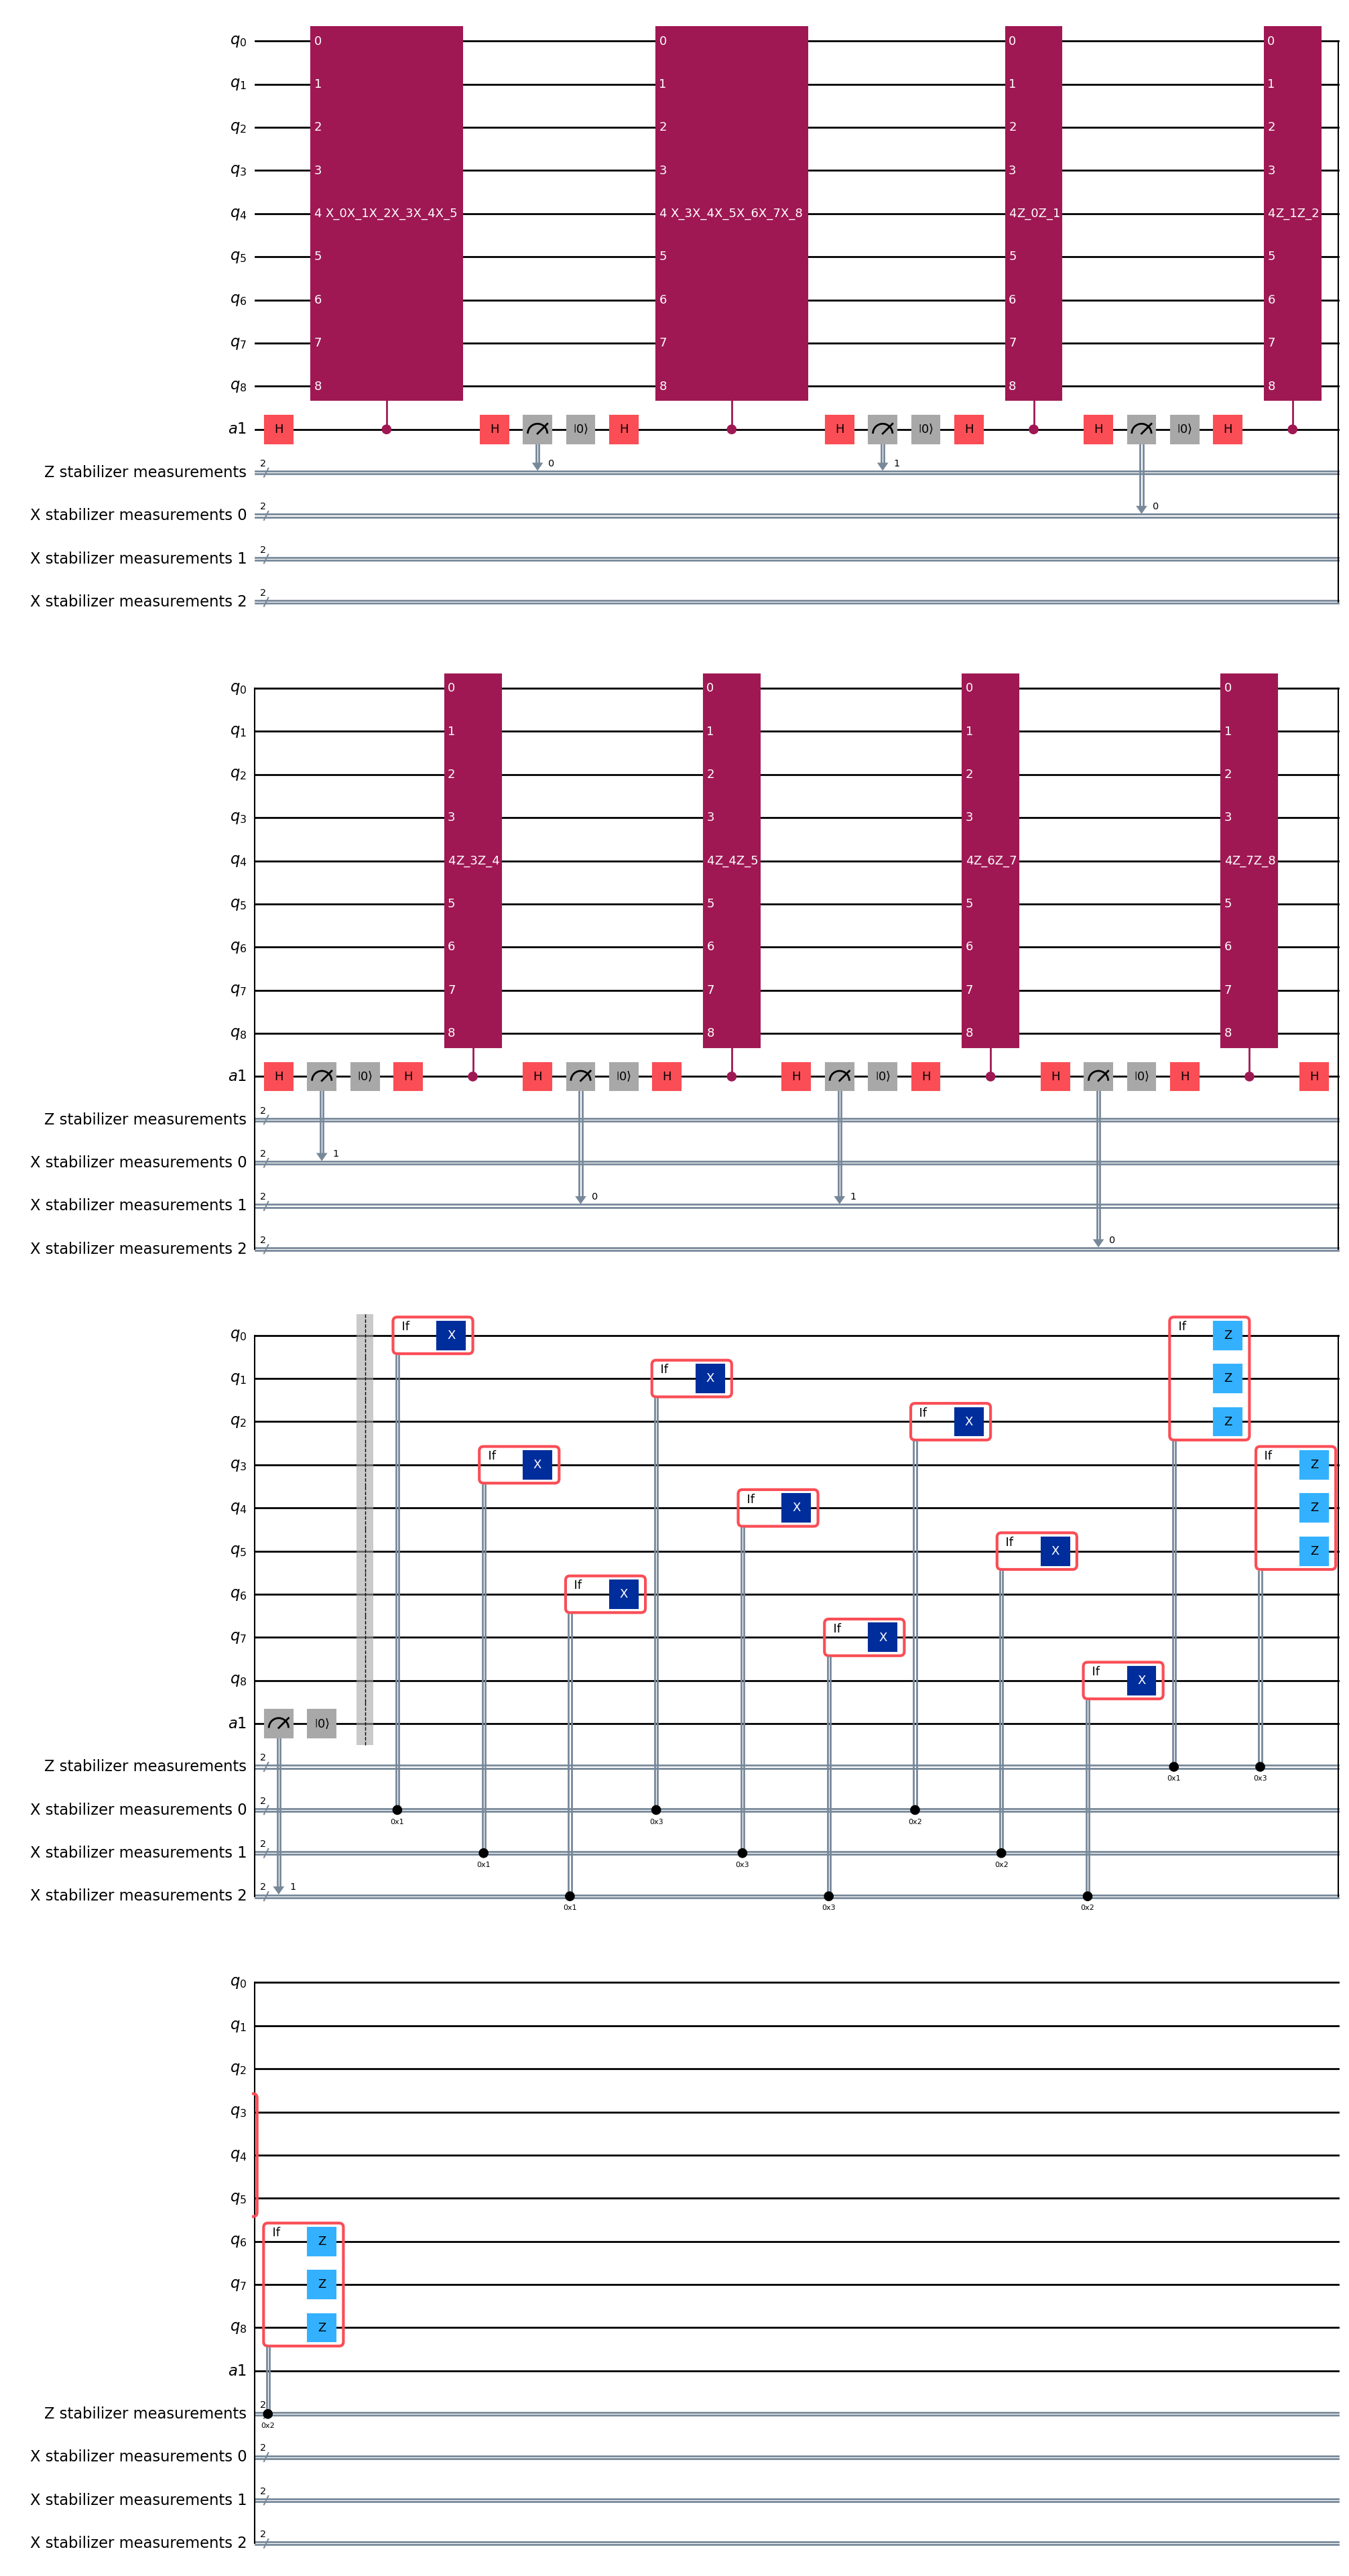

In [6]:
sq = ShorQubit()
qc = sq.syndrome_correction_circuit()

qc.draw('mpl')

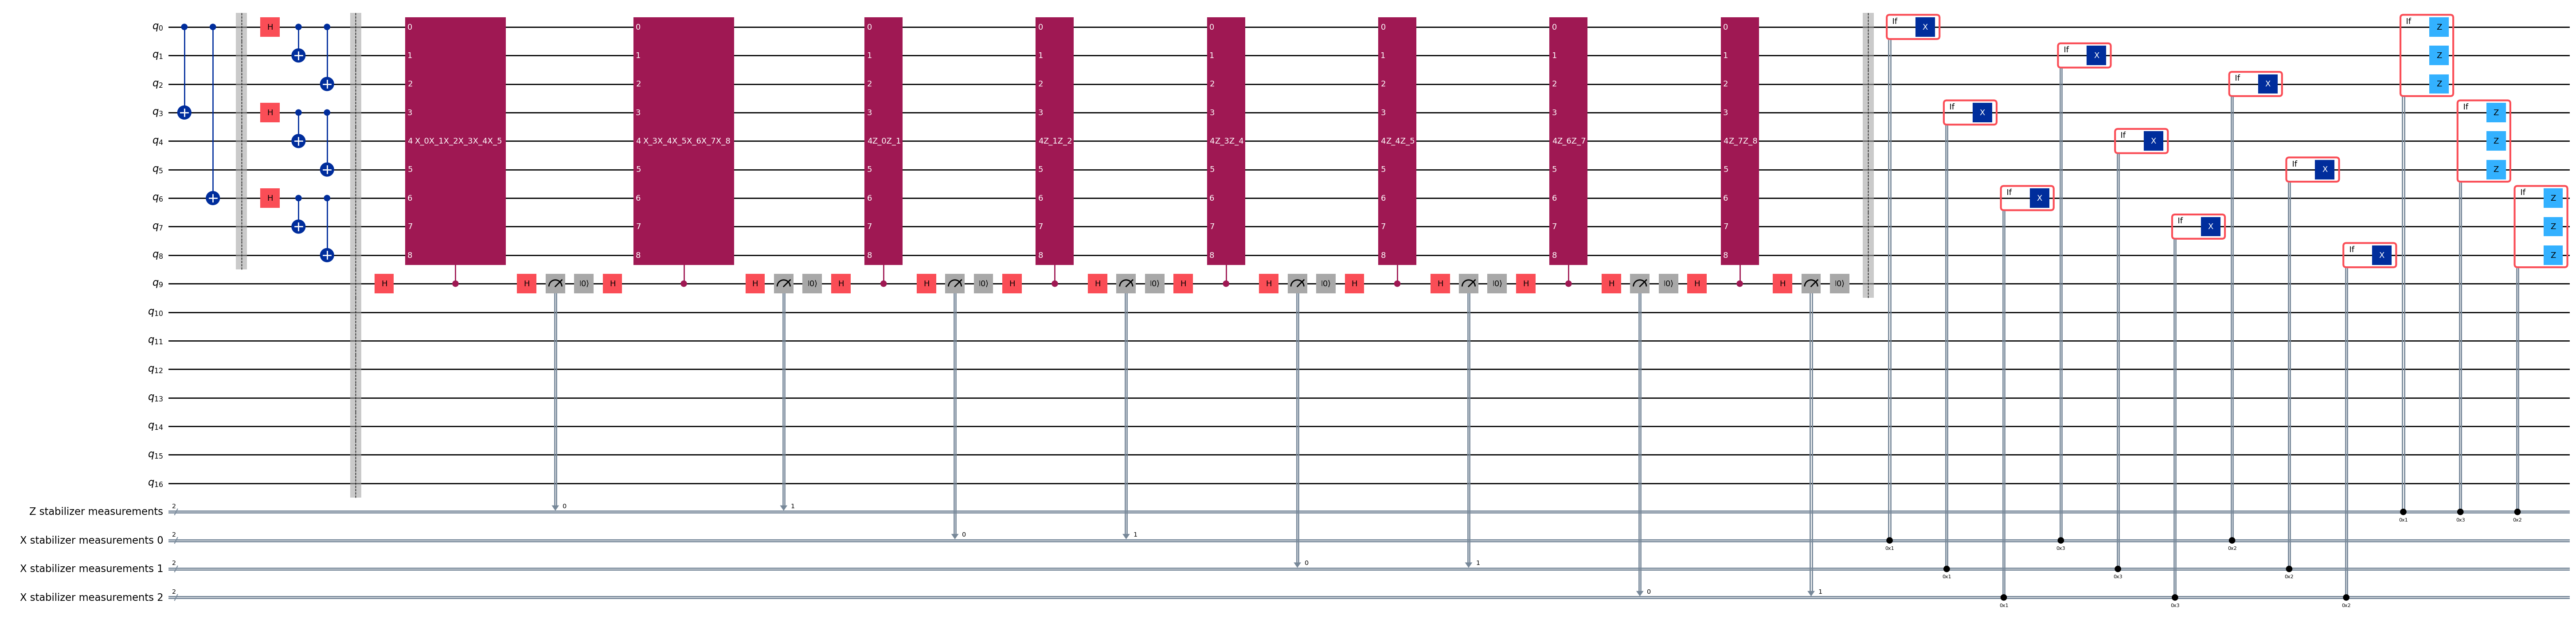

In [7]:
qc = sq.circuit()

qc.draw('mpl', fold=-1)